In [165]:
from pymongo import MongoClient
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from wsba import *
%matplotlib inline
from datetime import timedelta
import random
import numpy as np

In [12]:
# Pilfered from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(
    #font='Franklin Gothic Book',
    rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'lightgrey',
         'axes.facecolor': 'None',
         'axes.grid': False,
         'axes.labelcolor': 'dimgrey',
         'axes.spines.right': False,
         'axes.spines.top': False,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'w',
         'patch.force_edgecolor': True,
         'text.color': 'dimgrey',
         'xtick.bottom': True,
         'xtick.color': 'dimgrey',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'dimgrey',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})


In [14]:
getnumsubmissions()

1719

In [15]:
findone()

"{'_id': ObjectId('605bb15d5df7eedfb49c1b8b'), 'id': 'mcheu3', 'fullname': 't3_mcheu3', 'selftext': '', 'created_utc': '2021-03-24 17:38:13', 'num_comments': 0, 'score': 1, 'upvote_ratio': 1.0, 'is_original_content': False, 'permalink': '/r/wallstreetbets/comments/mcheu3/ill_just_blame_it_on_my_wifes_bf_those_16_shares/', 'title': 'I’ll just blame it on my wife’s bf. Those 16 shares came from his account . 🦍 🍌 🤡 honk honk . 🍦 ICE-CREAM !!! When the —— did we get ice-cream !', 'author': 'DaveThePOKEMONGuy', 'firstseen': '2021-03-24 21:38:37.006766'}"

Here is raw mongo to sort by date:
```    
db.wsb_submissions.aggregate( [ {
   $project: {
      'date': {
         $dateFromString: {
            dateString: '$created_utc'
         }
      }
   }
}, { $sort: { 'date' : 1} } ] )
```


In [16]:
date_sorted = wsbs.aggregate( [ {
   '$project': {
      'date': {
         '$dateFromString': {
            'dateString': '$created_utc'
         }
      }
   }
}, { '$sort': { 'date' : 1} } ] )

In [17]:
for x in date_sorted:
    print(x)
    break

{'_id': ObjectId('605bb2fe5df7eedfb49c1f56'), 'date': datetime.datetime(2021, 3, 18, 15, 8, 41)}


In [20]:
def getdaterange():
    first = None
    last = None
    dates_sorted = wsbs.aggregate( [ { '$project': { 'date': { '$dateFromString': 
        { 'dateString': '$created_utc' } } } }, { '$sort': { 'date' : 1} } ] )
    for val in dates_sorted:
        first = val
        break
    dates_sorted = wsbs.aggregate( [ { '$project': { 'date': { '$dateFromString': 
        { 'dateString': '$created_utc' } } } }, { '$sort': { 'date' : -1} } ] )
    for val in dates_sorted:
        last = val
        break
    
    return (first,last)

In [21]:
first,last = getdaterange()
last['date'].strftime('%m/%d/%y')

'04/01/21'

In [22]:
def groupbyauthor(show=False, min=0):
    authors = wsbs.aggregate([{"$group":{"_id":"$author","count": { "$sum":1 }}},{"$sort":{'count':-1}}])
    most = 10
    i = 0
    post_counts = []
    posters = []
    for x in authors:
        if x['count'] > 1 and show:
            print(x)
    
        if x['count'] >= min:
            i += 1
            post_counts.append(x['count'])
            posters.append(x['_id'])
            
    return (i, posters, post_counts)
    

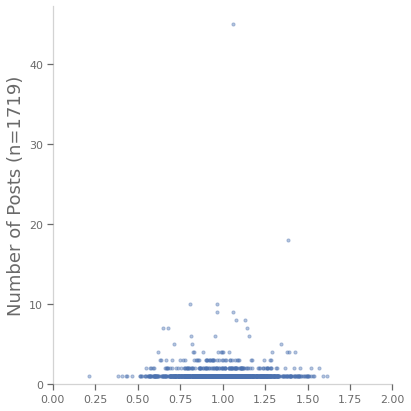

In [27]:
num, posters, post_counts = groupbyauthor()


fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(x=stats.norm.rvs(1,size=len(post_counts),scale=.2),
           y=post_counts,
           s=10,
           alpha=.4)
ax.set_ylabel(f'Number of Posts (n={sum(post_counts)})')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0,xmax=2)
plt.tight_layout()
#plt.savefig('figures/pda_numposts.png')

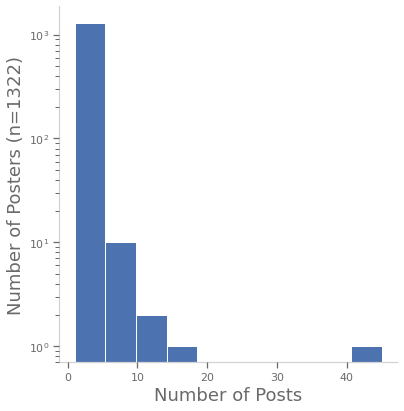

In [28]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.hist(x=post_counts)
ax.set_ylabel(f'Number of Posters (n={num})')
ax.set_xlabel('Number of Posts')
plt.tight_layout()
plt.yscale('log')
#plt.savefig('figures/pda_numposts_hist.png')

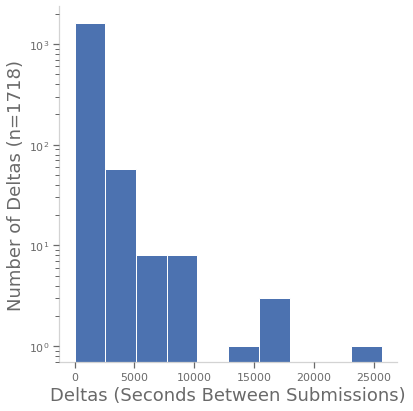

In [56]:
def getsubmissiondeltas(max=None,log=True,save=None):
    submission_dates = wsbs.aggregate( [ {
        '$project': {
            'date': {
                '$dateFromString': {
                    'dateString': '$created_utc'
                 }
             }
        }
    }, { '$sort': { 'date' : -1} } ] )
    
    i = 0
    lastTime = None
    deltas = []
    for x in submission_dates:
        i += 1
        if lastTime != None:
            delta = (lastTime - x['date']).seconds
            if max == None or delta <= max:
                deltas.append(delta)
        #print(i, x)
        lastTime = x['date']
        #if i >= 30:
        #    break
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.hist(x=deltas)
    ax.set_ylabel(f'Number of Deltas (n={len(deltas)})')
    ax.set_xlabel('Deltas (Seconds Between Submissions)')
    plt.tight_layout()
    if log:
        plt.yscale('log')
    if save:
        plt.savefig(save)
    return deltas

deltas = getsubmissiondeltas()

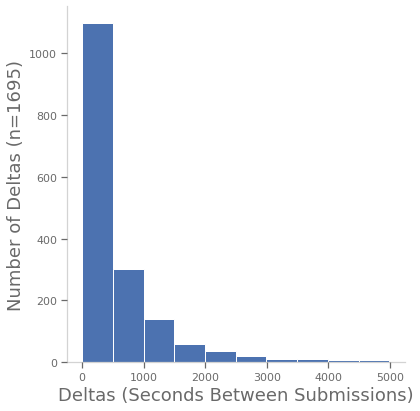

In [57]:
deltas = getsubmissiondeltas(max=5000,log=False)

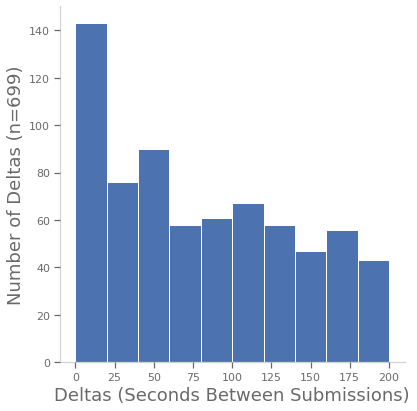

In [65]:
deltas = getsubmissiondeltas(max=200,log=False)

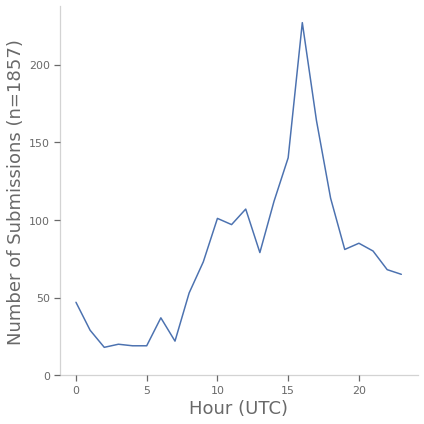

In [181]:
    
def groupby_hour(save=None):
    first = None
    last = None
    
    dates_sorted = wsbs.aggregate( [ 
        {
            '$project': {
                'hour': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%H"
                    }
                }
            }
        },
        {
            "$group": { 
                '_id':"$hour" ,
                'numsubmissions': { '$sum':1 }
            }#z
            
        },
        {
            "$sort":  { '_id': 1 } # This worked when there was a groupby for only a single field
            #"$sort":  { '_id': {'day':1, 'hour':1} }
        }
    ] )
    i = 0
    hours = []
    submissions = []
    for val in dates_sorted:
        hours.append(int(val['_id']))
        submissions.append(int(val['numsubmissions']))
        i += 1
        if i >= 10:
            pass
        
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(hours, submissions)
    ax.set_ylabel(f'Number of Submissions (n={sum(submissions)})')
    ax.set_xlabel('Hour (UTC)')
    plt.gca().set_ylim(bottom=0)
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
    
groupby_hour()

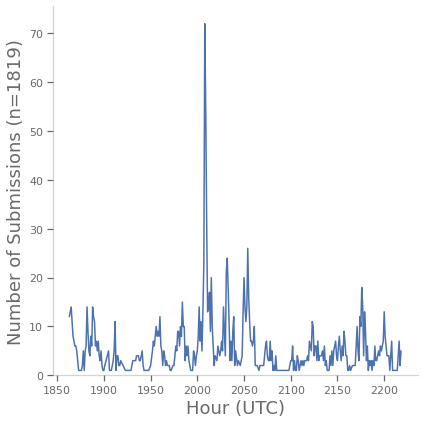

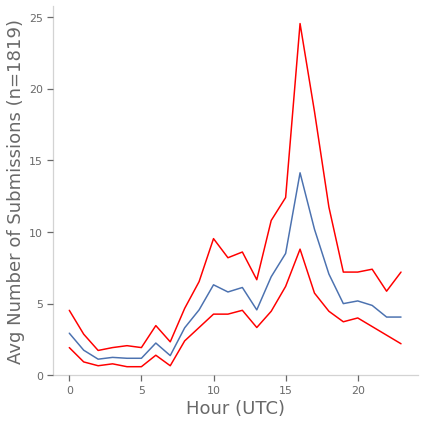

In [177]:
def groupby_monthday_hour():
    first = None
    last = None
    
    dates_sorted = wsbs.aggregate( [ 
        {
            '$project': {
                'hour': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%H"
                    }
                },
                'monthday': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%m%d"
                    }
                }
            }
        },
        {
            "$group": { 
                '_id':{'day':'$monthday','hour':"$hour"} ,
                'numsubmissions': { '$sum':1 }
            }#z
            
        },
        {
            "$sort":  { '_id': 1 } # This worked when there was a groupby for only a single field
            #"$sort":  { '_id': {'day':1, 'hour':1} }
        }
    ] )
    i = 0
    hours = []
    submissions = []
    for val in dates_sorted:
        #hours.append(int(val['_id']))
        submissions.append(int(val['numsubmissions']))
        print(val)
        i += 1
        if i >= 10:
            pass
        #break
    return
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(hours, submissions)
    ax.set_ylabel(f'Number of Submissions (n={sum(submissions)})')
    ax.set_xlabel('Hour (UTC)')
    plt.gca().set_ylim(bottom=0)
    plt.tight_layout()

    
def posts_per_hour(save=[None,None]):
    def hour_of_year(month,day,hour):
        '''given an hour, day, and month, return the number of hours since the beginning of the year'''
        dayspermonth =[0,31,28,31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        return hour + day*24 + sum(dayspermonth[:month]) * 24
    
    def add_zeros(num_hourly_submissions, num):
        '''
        adds zeros to each hourly submission until the total number of data points equals num
        '''
        for i, hour in enumerate(num_hourly_submissions):
            while len(num_hourly_submissions[i]) < num:
                num_hourly_submissions[i].append(0)
        return num_hourly_submissions
    
    def calc_avg_submissions_each_hour(num_hourly_submissions, num_days):
        '''
        given a list of submissions each hour, calculate the average number
        of submissions for each hour and return that in a list.
        
        num_days - used as the denominator in the calculation of the average
        '''
        submissions_each_hour = []
        for i, hour in enumerate(num_hourly_submissions):
            submissions_each_hour.append( sum(hour) / num_days)
        return submissions_each_hour
    
    def calc_bootstrap(num_hourly_submissions, num_samples=60_000):
        strap_space = np.zeros((24,num_samples))
        
        for hour, hour_sample_space in enumerate(num_hourly_submissions):
            for s in range(0,num_samples):
                strap_space[hour,s] = sum(random.choices(hour_sample_space,k=len(hour_sample_space))) / len(hour_sample_space)
        
        #print(strap_space)
        return strap_space
    
    dates_sorted = wsbs.aggregate( [ 
        {
            '$project': {
                'month': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%m"
                    }
                },
                'day': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%d"
                    }
                },
                'hour': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%H"
                    }
                }
            }
        },
        {
            "$group": { 
                '_id':{'month':'$month','day':'$day','hour':"$hour"} ,
                'numsubmissions': { '$sum':1 }
            }#z
            
        },
        {
            "$sort":  { '_id': 1 } # This worked when there was a groupby for only a single field
            #"$sort":  { '_id': {'day':1, 'hour':1} }
        }
    ] )
    i = 0
    hours = []
    submissions = []
    unique_days = []
    
    
    
    #submissions_each_hour is a list of lists
    # submissions_each_hour[0] returns a list of submissions during midnight across all days
    # submissions_each_hour[1] returns a list of submissions during 1am across all days
    # and so on
    submissions_each_hour = []
    for hour in range(0,24):
        submissions_each_hour.append([])
        
    for val in dates_sorted:
        submissions_each_hour[ int(val['_id']['hour']) ].append( int(val['numsubmissions']) )
        hours.append(hour_of_year(int(val['_id']['month']),int(val['_id']['day']),int(val['_id']['hour'])))
        submissions.append(int(val['numsubmissions']))
        unique_day = val['_id']['month'] + val['_id']['day']
        if not unique_day in unique_days:
            unique_days.append(unique_day)
        #print(val)
        i += 1
        if i >= 10:
            pass
        #break
    
    # used to choose a denominator when calculating average submissions per hour
    most_hourly_observations = 0 
    
    for i,hour in enumerate(submissions_each_hour):
        #print(f'{i}:{len(hour)} {hour}')
        if len(hour) > most_hourly_observations:
            most_hourly_observations = len(hour)
    
    submissions_each_hour = add_zeros(submissions_each_hour, most_hourly_observations)
    
    #for i,hour in enumerate(submissions_each_hour):
    #    print(f'{i}:{len(hour)} {hour}')
    
    
    
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(hours, submissions)
    ax.set_ylabel(f'Number of Submissions (n={sum(submissions)})')
    ax.set_xlabel('Hour (UTC)')
    plt.gca().set_ylim(bottom=0)
    plt.tight_layout()
    if save[0]:
        plt.savefig(save[0])
    
    bootstrap = calc_bootstrap(submissions_each_hour)
    avg_submissions_each_hour = calc_avg_submissions_each_hour(submissions_each_hour, len(unique_days))
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(range(0,24), avg_submissions_each_hour)
    ax.plot(range(0,24), np.percentile(bootstrap, 2.5, axis=1), c='red')
    ax.plot(range(0,24), np.percentile(bootstrap, 97.5, axis=1), c='red')
    ax.set_ylabel(f'Avg Number of Submissions (n={sum(submissions)})')
    ax.set_xlabel('Hour (UTC)')
    plt.gca().set_ylim(bottom=0)
    plt.tight_layout()
    if save[1]:
        plt.savefig(save[1])
    
        
posts_per_hour()

printing
printing
printing
printing
printing
printing


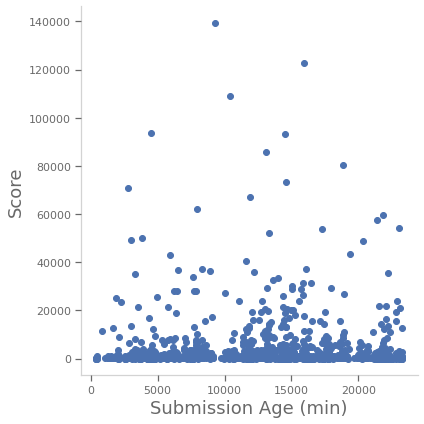

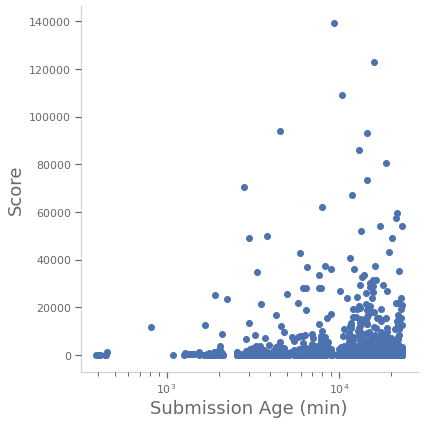

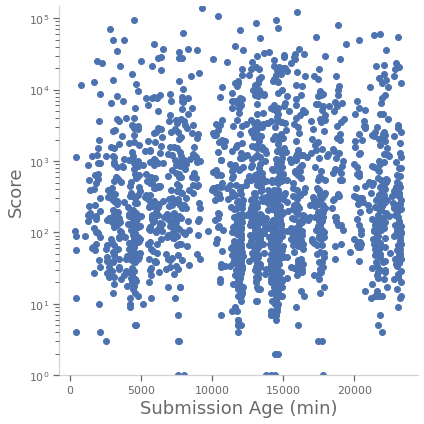

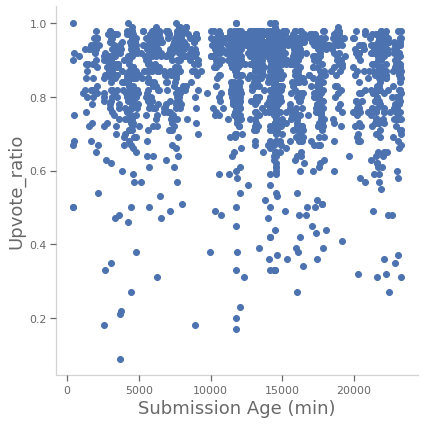

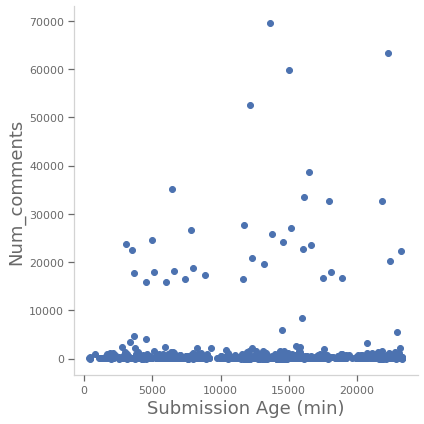

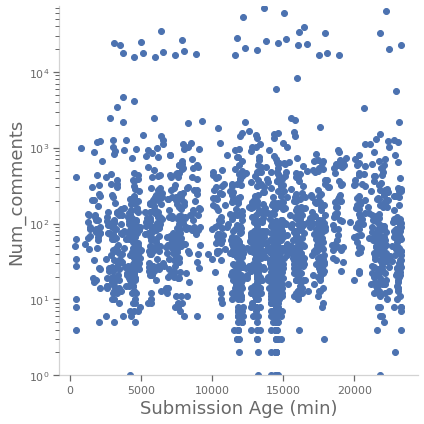

In [220]:
def field_by_age(field='score',logx=False,logy=False,save=False,ymax=None,ymin=None):
    age = wsbs.aggregate( [ 
        {
            '$project': {
                'minutes_old': {
                    '$divide': [
                        {
                            '$subtract': [
                                { '$dateFromString': {'dateString': '$lastseen' } },
                                { '$dateFromString': {'dateString': '$created_utc' } }
                            ]
                        }, 60_000 # per hour: 3_600_000
                        
                    ]
                },
                f'{field}': 1
            }
        }
    ] )
    
    i = 0
    data = []
    ages = []
    for item in age:
        i += 1
        data.append(item[field])
        ages.append(item['minutes_old'])

    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.scatter(ages, data)
    ax.set_ylabel(field.capitalize())
    ax.set_xlabel('Submission Age (min)')
    if ymin:
        plt.gca().set_ylim(bottom=ymin)
    if ymax:
        plt.gca().set_ylim(top=ymax)
    
    if logx:
        plt.xscale('log')
        logx = '_logx'
    else:
        logx = ''

    if logy:
        plt.yscale('log')
        logy = '_logy'
    else:
        logy = ''

    plt.tight_layout()
    if save:
        filename = f'figures/{field}_by_age{logx}{logy}.png'
        plt.savefig(filename)
        return filename

field_by_age('score')
field_by_age('score',logx=True)
field_by_age('score',ymin=1,logy=True)
field_by_age('upvote_ratio')
#field_by_age('upvote_ratio',logx=True)
field_by_age('num_comments')
field_by_age('num_comments',ymin=1,logy=True)
#field_by_age('num_comments',logy=True)